## Evaluate RAG Pipeline End-End

In [1]:
# provide project root path
ProjectRoot = "/home/sangram/Tutorbot_capstone/git_hub/Tutorbot/"
DatasetRoot = ProjectRoot + "Dataset/"

#DatasetRoot = "/content/drive/MyDrive/"

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
# Clear HuggingFace Cache

!du -hs ~/.cache/*
!rm -rf ~/.cache/huggingface

56K	/home/sangram/.cache/chroma
632K	/home/sangram/.cache/fontconfig
25G	/home/sangram/.cache/huggingface
14M	/home/sangram/.cache/jedi
56K	/home/sangram/.cache/matplotlib
56K	/home/sangram/.cache/mesa_shader_cache
169M	/home/sangram/.cache/mozilla
272K	/home/sangram/.cache/outlines
5.4G	/home/sangram/.cache/pip
32K	/home/sangram/.cache/sessions
280K	/home/sangram/.cache/torch
96K	/home/sangram/.cache/torch_extensions


### Dependencies

In [4]:
try:
    import bert_score
except ImportError:
    !pip install bert_score

try:
    from evaluate import load
except ImportError:
    !pip install evaluate

try:
    import rouge_score
except ImportError:
    !pip install rouge_score

try:
    import einops
except ImportError:
    !pip install einops

try:
    import flash_attn
except ImportError:
    !pip install flash_attn

try:
    import chromadb
except ImportError:
    !pip install chromadb

try:
    import sentence_transformers
except ImportError:
    !pip install -U sentence-transformers

try:
    import absl
except ImportError:
    !pip install absl-py

try:
    import sentencepiece
except ImportError:
    !pip install sentencepiece

try:
    import openai
except ImportError:
    !pip install openai

Defaulting to user installation because normal site-packages is not writeable
  Using cached flash_attn-2.6.3.tar.gz (2.6 MB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [21 lines of output]
      fatal: not a git repository (or any parent up to mount point /)
      Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
      /tmp/pip-install-f_gbhmp1/flash-attn_8e5428b98ab143678408c2c3bf137179/setup.py:95: UserWarning: flash_attn was requested, but nvcc was not found.  Are you sure your environment has nvcc available?  If you're installing within a container from https://hub.docker.com/r/pytorch/pytorch, only images whose names contain 'devel' will provide nvcc.
        warnings.warn(
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pi

In [5]:
import pandas as pd
import numpy as np
import json
import re

# LLM
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import T5ForConditionalGeneration, T5Tokenizer
from transformers import pipeline
import gc

# Information Retrieval (IR)
# from ragatouille import RAGPretrainedModel
import chromadb
from sentence_transformers import SentenceTransformer

# evaluate
import bert_score
from evaluate import load
from tqdm.notebook import tqdm

# viz
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# load context and question test set which was created by doc2query
test_df = pd.read_csv(DatasetRoot + 'q_a_testset.csv')
if 'raw_para_id' not in test_df.columns:
  test_df['raw_para_id'] = test_df.index
test_df.head()

,raw_para_id,paragraph,question,Final_answer
0,0,data science is an interdisciplinary academic ...,what is data science?,Data science is an interdisciplinary academic ...
1,1,data science is multifaceted and can be descri...,what is data science?,Data science
2,2,"data science is a concept to unify statistics,...",How does data science change the world?,Data science is changing the world by introduc...
3,3,data scientist creates programming code and co...,"what's the meaning of ""data scientist"" in comp...",A data scientist in computer science is a prof...
4,4,the field includes preparing data for analysis...,Is data science a pure data science?,"No, data science is not a pure data science."


In [7]:
# loading full article from json file
with open(DatasetRoot + 'raw_knowledge.json', 'r') as f:
    raw_text_json = json.load(f)
raw_text_list = [text for _, text in raw_text_json.items()]
# raw_text_list = raw_text_json

if not isinstance(raw_text_list, list):
    raise TypeError("Expected raw_text_list to be a list.")

In [8]:
# dataframe holding metrics for different RAG models
RAGmodel_metrics_df = pd.DataFrame(columns=['Model', 'BERTScore_Precision', 'BERTScore_Recall', 'BERTScore_F1', 'METEOR', 'Rouge1', 'Rouge2', 'RougeL', 'RougeLsum'])

In [9]:
if torch.cuda.is_available():
    torch.set_default_device("cuda")
    print("CUDA is available!!")
else:
    raise RuntimeError("CUDA is not available!! LLM cannot run, rerun with GPU")

CUDA is available!!


### Helper Methods

In [10]:
def calculate_metrics(metrics_df, model_name, candidate_answers, true_answers):
    # Calculate BERTScore
    # bert_metrics = bert_score.score(cands=candidate_answers, refs=true_answers, model_type='roberta-large', nthreads=4)
    bert_metrics = bert_score.score(cands=candidate_answers, refs=true_answers, model_type='bert-base-uncased', nthreads=4)

    # Fetch precision, recall, F1 score from BERT score (https://lightning.ai/docs/torchmetrics/stable/text/bert_score.html)
    BERTScore_Precision = np.mean(np.array(bert_metrics[0]))
    BERTScore_Recall = np.mean(np.array(bert_metrics[1]))
    BERTScore_F1 =  np.mean(np.array(bert_metrics[2]))
    print(f"BERTScore Precision: {BERTScore_Precision}")
    print(f"BERTScore Recall: {BERTScore_Recall}")
    print(f"BERTScore F1 Score: {BERTScore_F1}")

    # calculate meteor via https://huggingface.co/spaces/evaluate-metric/meteor
    meteor = load('meteor')
    Meteor_score = meteor.compute(predictions=candidate_answers, references=true_answers)
    Meteor_score = Meteor_score['meteor']
    print(f"METEOR Score: {Meteor_score}")

    # calculate rouge via https://huggingface.co/spaces/evaluate-metric/rouge
    rouge = load("rouge")
    rouge_score = rouge.compute(predictions=candidate_answers, references=true_answers)
    print(f"ROUGE Score: {rouge_score}")
    Rouge1  = rouge_score['rouge1']
    Rouge2  = rouge_score['rouge2']
    RougeL  = rouge_score['rougeL']
    RougeLsum = rouge_score['rougeLsum']

    # record results
    new_row = pd.DataFrame({
        'Model': [model_name],
        'BERTScore_Precision': [BERTScore_Precision],
        'BERTScore_Recall': [BERTScore_Recall],
        'BERTScore_F1': [BERTScore_F1],
        'METEOR': [Meteor_score],
        'Rouge1': [Rouge1],
        'Rouge2': [Rouge2],
        'RougeL': [RougeL],
        'RougeLsum': [RougeLsum]
    })

    metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

    return metrics_df

In [11]:
# RAG Pipeline wrapper
def AskRAG(question):
    # get top relevant doc
    retrieved_doc = retriever.search(question, k=1)
    # pass context and query to get answer
    # return AskLLM(retrieved_doc[0]['content'], question)
    return AskLLM(retrieved_doc, question)

In [12]:
# release GPU mem
def FreeGPUMem(model=None, tokenizer=None):
    if torch.cuda.is_available():
        # GPU memory before freeing
        initial_free_memory, _ = torch.cuda.mem_get_info()

        if model:
            del model
        if tokenizer:
            del tokenizer

        # garbage collection and empty cache
        gc.collect()
        torch.cuda.empty_cache()

        # GPU memory after freeing
        final_free_memory, _ = torch.cuda.mem_get_info()

        released_memory_mb = (final_free_memory - initial_free_memory) / (1024 ** 2)
        print(f"Freed {released_memory_mb:.2f} MB of GPU memory.")
    return None


### Initialize Retriever

In [13]:
# ragatouille
# retriever = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")
# index_path = retriever.index(index_name="knowledgestore_index", collection=raw_text_list)
# retriever = RAGPretrainedModel.from_index(index_path)

In [14]:
# chromadb vector store + colbert-ir/colbertv2.0 embedding
class RetrieverDB:
  def __init__(self, raw_text):
    # setup Chroma in-memory
    client = chromadb.Client()
    self.retriever_colbertv2 = client.create_collection("knowledge-store-chromadb")
    # embed raw text
    self.embed_model = SentenceTransformer("colbert-ir/colbertv2.0")
    raw_text_embeddings = [self.embed_model.encode(text).tolist() for text in raw_text]
    # Add docs to the knowledge store
    raw_text_ids = [str(idx) for idx in range(len(raw_text))]
    self.retriever_colbertv2.add(embeddings=raw_text_embeddings, documents=raw_text_list, ids=raw_text_ids)

  def search(self, question, k=1):
    # embed query into vector
    query_embedding = self.embed_model.encode(question).tolist()
    # get top k docs for context
    retrieved_docs = self.retriever_colbertv2.query(query_embeddings=query_embedding, n_results=k)
    context = ' '.join([doc for doc in retrieved_docs['documents'][0]])
    return context


In [15]:
# init
retriever = RetrieverDB(raw_text=raw_text_list)

No sentence-transformers model found with name colbert-ir/colbertv2.0. Creating a new one with MEAN pooling.


config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

### Evaluate distilbert/distilbert-base-cased-distilled-squad

In [16]:
model = pipeline("question-answering", model='distilbert-base-cased-distilled-squad')

config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [17]:
# LLM inference wrapper
def AskLLM(context, question):
    answer = model(question=question, context=context)
    final_answer = answer['answer']
    return final_answer

In [18]:
candidate_answers = []
true_answers = []

for _, eval_data in tqdm(test_df.iterrows()):
    question = eval_data.question

    true_answers.append(eval_data.Final_answer)
    candidate_answers.append(AskRAG(question))

0it [00:00, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


#### Calculate Different metric scores

In [19]:
RAGmodel_metrics_df = calculate_metrics(metrics_df = RAGmodel_metrics_df, model_name = "distilbert/distilbert-base-cased-distilled-squad", candidate_answers = candidate_answers, true_answers = true_answers)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTScore Precision: 0.5587867498397827
BERTScore Recall: 0.47343185544013977
BERTScore F1 Score: 0.5046887993812561


[nltk_data] Downloading package wordnet to /home/sangram/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/sangram/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/sangram/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


METEOR Score: 0.12002757660874404


ROUGE Score: {'rouge1': 0.18271512196920037, 'rouge2': 0.08755623461505813, 'rougeL': 0.17481439525619052, 'rougeLsum': 0.16914234526713304}


In [20]:
# cleanup GPU memory
FreeGPUMem(model)

del model

Freed 846.00 MB of GPU memory.


### Evaluate deepset/roberta-base-squad2-distilled

In [21]:
model = pipeline("question-answering", model='deepset/roberta-base-squad2-distilled')

config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/295 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [22]:
# LLM inference wrapper
def AskLLM(context, question):
    answer = model(question=question, context=context)
    final_answer = answer['answer']
    return final_answer

In [23]:
candidate_answers = []
true_answers = []

for _, eval_data in tqdm(test_df.iterrows()):
    question = eval_data.question

    true_answers.append(eval_data.Final_answer)
    candidate_answers.append(AskRAG(question))

0it [00:00, ?it/s]

#### Calculate Different metric scores

In [24]:
RAGmodel_metrics_df = calculate_metrics(metrics_df = RAGmodel_metrics_df, model_name = "deepset/roberta-base-squad2-distilled", candidate_answers = candidate_answers, true_answers = true_answers)

BERTScore Precision: 0.5912023186683655
BERTScore Recall: 0.5056185722351074
BERTScore F1 Score: 0.5383003354072571


[nltk_data] Downloading package wordnet to /home/sangram/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/sangram/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/sangram/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


METEOR Score: 0.1316006307463602
ROUGE Score: {'rouge1': 0.20116430463224455, 'rouge2': 0.08706817462457331, 'rougeL': 0.1828513034890686, 'rougeLsum': 0.1781502540548593}


In [25]:
# cleanup GPU memory
FreeGPUMem(model)

del model

Freed 784.00 MB of GPU memory.


### Evaluate google/flan-t5-large

In [26]:
model_name = "google/flan-t5-large"
model = T5ForConditionalGeneration.from_pretrained(model_name, torch_dtype="auto", trust_remote_code=True)
tokenizer = T5Tokenizer.from_pretrained(model_name, trust_remote_code=True)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [27]:
def generate_prompt(context, query):
    prompt = f"""Give the answer to the user query delimited by triple backticks ```{query}```
                using the information given in context delimited by triple backticks ```{context}```.
                If there is no relevant information in the provided context, tell user that you did not have any relevant context to base your answer on. Be concise and output the answer.
                """
    return prompt

In [28]:
# LLM inference wrapper
def AskLLM(context, question):
    prompt = generate_prompt(context, question)

    inputs = tokenizer(prompt, return_tensors="pt", return_attention_mask=True)

    # Ask LLM to answer
    outputs = model.generate(**inputs, max_length=500)
    final_answer = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return final_answer

In [29]:
candidate_answers = []
true_answers = []

for _, eval_data in tqdm(test_df.iterrows()):
    question = eval_data.question

    true_answers.append(eval_data.Final_answer)
    candidate_answers.append(AskRAG(question))

0it [00:00, ?it/s]

#### Calculate Different metric scores

In [30]:
RAGmodel_metrics_df = calculate_metrics(metrics_df = RAGmodel_metrics_df, model_name = "google/flan-t5-large", candidate_answers = candidate_answers, true_answers = true_answers)

BERTScore Precision: 0.6058480739593506
BERTScore Recall: 0.640688419342041
BERTScore F1 Score: 0.6168190240859985


[nltk_data] Downloading package wordnet to /home/sangram/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/sangram/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/sangram/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


METEOR Score: 0.30012056434434464
ROUGE Score: {'rouge1': 0.36027031882481914, 'rouge2': 0.1842415593857859, 'rougeL': 0.32244776036298867, 'rougeLsum': 0.32477619399770696}


In [31]:
# cleanup GPU memory
FreeGPUMem(model, tokenizer)

del model
del tokenizer

Freed 3764.00 MB of GPU memory.


### Evaluate Microsoft/Phi-2

In [32]:
!nvidia-smi

Fri Aug  2 00:33:20 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-PCIE-16GB           On  |   00000000:3B:00.0 Off |                    0 |
| N/A   34C    P0             42W /  250W |    4021MiB /  16384MiB |      0%   E. Process |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [33]:
model_name = "microsoft/phi-2"
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype="auto", trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [34]:
def generate_prompt_fewshot(context, question):
    prompt_template = """
You are an expert in understanding and interpreting provided text contexts. Given a context and a question, your task is to generate an accurate and informative answer based on the provided context. Here is the structure:

1. **Context:** The detailed text or passage that contains the information needed to answer the question.
2. **Question:** A specific question that needs to be answered based on the context.

Please make sure your response is clear, concise, and directly addresses the question. If the context does not contain sufficient information to answer the question, say I don't know.

**Example:**

**Context:**
"The rainforests of the Amazon are home to a vast diversity of species, including numerous plants, animals, and insects. These forests play a crucial role in regulating the Earth's climate by absorbing carbon dioxide and releasing oxygen. However, deforestation poses a significant threat to these ecosystems, leading to loss of habitat and biodiversity."

**Question:**
"Why are the rainforests of the Amazon important for the Earth's climate?"

**Answer:**
"The rainforests of the Amazon are important for the Earth's climate because they absorb carbon dioxide and release oxygen, helping to regulate the climate."

Please follow this format for each question:

**Context:**
{context}

**Question:**
{question}

**Final Answer:**
"""
    return prompt_template.format(context=context, question=question)

In [35]:
# LLM inference wrapper
def AskLLM(context, question):
    prompt = generate_prompt_fewshot(context, question)

    inputs = tokenizer(prompt, return_tensors="pt", return_attention_mask=True)

    # Ask LLM to answer
    outputs = model.generate(**inputs, max_length=500, pad_token_id=tokenizer.eos_token_id)
    text = tokenizer.batch_decode(outputs)[0]

    # Regular expression to extract the Final Answer
    answer_pattern = r"\*\*Final Answer:\*\*\s*(.*)<|endoftext|>"

    # Extract answer from LLM response
    match = re.search(answer_pattern, text, re.DOTALL)
    final_answer = ""
    if match:
        final_answer = match.group(1).strip()
        # print("Final Answer:", final_answer)
    else:
        print("Final Answer not found !!!")

    return final_answer


In [36]:
candidate_answers = []
true_answers = []

for _, eval_data in tqdm(test_df.iterrows()):
    question = eval_data.question

    true_answers.append(eval_data.Final_answer)
    candidate_answers.append(AskRAG(question))

0it [00:00, ?it/s]

#### Calculate Different metric scores

In [37]:
RAGmodel_metrics_df = calculate_metrics(metrics_df = RAGmodel_metrics_df, model_name = "Microsoft/Phi-2", candidate_answers = candidate_answers, true_answers = true_answers)

BERTScore Precision: 0.5528107285499573
BERTScore Recall: 0.6746748089790344
BERTScore F1 Score: 0.5944495797157288


[nltk_data] Downloading package wordnet to /home/sangram/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/sangram/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/sangram/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


METEOR Score: 0.36564005129769067
ROUGE Score: {'rouge1': 0.3505723699743737, 'rouge2': 0.23732582626530568, 'rougeL': 0.32253057218407555, 'rougeLsum': 0.32612581414133324}


In [38]:
!nvidia-smi

Fri Aug  2 00:35:03 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-PCIE-16GB           On  |   00000000:3B:00.0 Off |                    0 |
| N/A   37C    P0             43W /  250W |   13181MiB /  16384MiB |      0%   E. Process |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [39]:
# cleanup GPU memory
FreeGPUMem(model, tokenizer)

del model
del tokenizer

Freed 6388.00 MB of GPU memory.


### Evaluate Qwen/Qwen2-1.5B-Instruct

In [40]:
!nvidia-smi

Fri Aug  2 00:35:04 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-PCIE-16GB           On  |   00000000:3B:00.0 Off |                    0 |
| N/A   37C    P0             44W /  250W |    6793MiB /  16384MiB |     88%   E. Process |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [41]:
# for RuntimeError: cutlassF: no kernel found to launch! | https://huggingface.co/stabilityai/stable-cascade/discussions/11
torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)

model_name = "Qwen/Qwen2-1.5B-Instruct"
model_qwen = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype="auto", trust_remote_code=True)
tokenizer_qwen = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

qwen_pipeline = pipeline(
    "text-generation",
    model=model_qwen,
    tokenizer=tokenizer_qwen,
)


config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [42]:
def generate_prompt(context, question):
    prompt_template = """
You are an expert in understanding and interpreting provided text contexts. Given a context and a question, your task is to generate an accurate and informative answer based on the provided context. Here is the structure:

1. **Context:** The detailed text or passage that contains the information needed to answer the question.
2. **Question:** A specific question that needs to be answered based on the context.

Please make sure your response is clear, concise, and directly addresses the question. If the context does not contain sufficient information to answer the question, say I don't know.

**Context:**
{context}

**Question:**
{question}

The response is a valid JSON with fields `explanation` and `response`.
"""
    return prompt_template.format(context=context, question=question)

In [43]:
# LLM inference wrapper
def AskLLM(context, question):
    
    prompt = generate_prompt(context, question)
    messages = [{"role": "user", "content": prompt}]
    generation_args = {
        "max_new_tokens": 500,
        "return_full_text": False,
        "temperature": 0.1, # to make confident responses
        "do_sample": True,
    }

    # Ask LLM to answer 
    output = qwen_pipeline(messages, **generation_args)
    answer = output[0]['generated_text']

    final_answer = "I don't know."

    # Extract the answer
    json_match = re.search(r'{.*}', answer, re.DOTALL)

    if json_match:
        # extract and parse JSON
        try:
            json_string = json_match.group(0)
            response_dict = json.loads(json_string)
            final_answer = response_dict['response']
        except json.JSONDecodeError:
            print(f"Error decoding JSON: {json_string}")

    return final_answer

In [44]:
candidate_answers = []
true_answers = []

for _, eval_data in tqdm(test_df.iterrows()):
    question = eval_data.question

    true_answers.append(eval_data.Final_answer)
    candidate_answers.append(AskRAG(question))

0it [00:00, ?it/s]

Error decoding JSON: {
"explanation": "Thomas H. Davenport and DJ Patil were the technologists who were called the sexiest job of the 21st century.",
"response": "Thomas H. Davenport and DJ Patil have been called the sexiest job of the 21st century because their declaration about data scientists being in high demand resonated with many people and became a widely recognized phrase.",
}


#### Calculate Different metric scores

In [45]:
RAGmodel_metrics_df = calculate_metrics(metrics_df = RAGmodel_metrics_df, model_name = "Qwen/Qwen2-1.5B-Instruct", candidate_answers = candidate_answers, true_answers = true_answers)

BERTScore Precision: 0.5361098647117615
BERTScore Recall: 0.6024031043052673
BERTScore F1 Score: 0.5517389178276062


[nltk_data] Downloading package wordnet to /home/sangram/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/sangram/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/sangram/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


METEOR Score: 0.27621989987610235
ROUGE Score: {'rouge1': 0.2941715629870242, 'rouge2': 0.17758851736111878, 'rougeL': 0.2657859028003118, 'rougeLsum': 0.2667112930373233}


In [46]:
!nvidia-smi

Fri Aug  2 00:37:18 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-PCIE-16GB           On  |   00000000:3B:00.0 Off |                    0 |
| N/A   37C    P0             43W /  250W |   10531MiB /  16384MiB |      0%   E. Process |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [47]:
# revert CUDA settings to default ones
torch.backends.cuda.enable_mem_efficient_sdp(True)
torch.backends.cuda.enable_flash_sdp(True)

# cleanup GPU memory
FreeGPUMem(model=model_qwen, tokenizer=tokenizer_qwen)

del qwen_pipeline
del model_qwen
del tokenizer_qwen

Freed 5784.00 MB of GPU memory.


### Evaluate Microsoft/Phi-3

In [48]:
!nvidia-smi

Fri Aug  2 00:37:19 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-PCIE-16GB           On  |   00000000:3B:00.0 Off |                    0 |
| N/A   37C    P0             43W /  250W |    4747MiB /  16384MiB |     96%   E. Process |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [49]:
model_name = "microsoft/Phi-3-mini-4k-instruct"
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype="auto", trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

phi3_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

configuration_phi3.py:   0%|          | 0.00/11.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/73.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/16.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [50]:
def generate_prompt_fewshot(context, question):
    prompt_template = """
You are an expert in understanding and interpreting provided text contexts. Given a context and a question, your task is to generate an accurate and informative answer based on the provided context. Here is the structure:

1. **Context:** The detailed text or passage that contains the information needed to answer the question.
2. **Question:** A specific question that needs to be answered based on the context.

Please make sure your response is clear, concise, and directly addresses the question. If the context does not contain sufficient information to answer the question, say I don't know.

**Example:**

**Context:**
"The rainforests of the Amazon are home to a vast diversity of species, including numerous plants, animals, and insects. These forests play a crucial role in regulating the Earth's climate by absorbing carbon dioxide and releasing oxygen. However, deforestation poses a significant threat to these ecosystems, leading to loss of habitat and biodiversity."

**Question:**
"Why are the rainforests of the Amazon important for the Earth's climate?"

**Answer:**
"The rainforests of the Amazon are important for the Earth's climate because they absorb carbon dioxide and release oxygen, helping to regulate the climate."

Please follow this format for each question:

**Context:**
{context}

**Question:**
{question}

**Final Answer:**
"""
    return prompt_template.format(context=context, question=question)


# LLM inference wrapper
def AskLLM(context, question):

    prompt = generate_prompt_fewshot(context, question)
    messages = [
    {"role": "user", "content": prompt}]

    generation_args = {
        "max_new_tokens": 500,
        "return_full_text": False,
        "temperature": 0.1, # to make confident responses
        "do_sample": True,
    }

    output = phi3_pipeline(messages, **generation_args)
    text = output[0]['generated_text']

    # Regular expression to extract the Final Answer
    answer_pattern = r"\*\*Final Answer:\*\*\s*(.*)"

    # Extract answer from LLM response
    match = re.search(answer_pattern, text, re.DOTALL)
    final_answer = "I don't know"
    if match:
        final_answer = match.group(1).strip()
        # print("Final Answer:", final_answer)
    else:
        print("Final Answer not found !!!")

    return final_answer


In [51]:
candidate_answers = []
true_answers = []

for _, eval_data in tqdm(test_df.iterrows()):
    question = eval_data.question

    true_answers.append(eval_data.Final_answer)
    candidate_answers.append(AskRAG(question))


0it [00:00, ?it/s]

The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.


Final Answer not found !!!
Final Answer not found !!!
Final Answer not found !!!
Final Answer not found !!!
Final Answer not found !!!
Final Answer not found !!!


#### Calculate Different metric scores

In [52]:
RAGmodel_metrics_df = calculate_metrics(metrics_df = RAGmodel_metrics_df, model_name = "Microsoft/Phi-3", candidate_answers = candidate_answers, true_answers = true_answers)

BERTScore Precision: 0.5582917928695679
BERTScore Recall: 0.6599736213684082
BERTScore F1 Score: 0.596000611782074


[nltk_data] Downloading package wordnet to /home/sangram/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/sangram/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/sangram/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


METEOR Score: 0.381685599875955
ROUGE Score: {'rouge1': 0.35465707363982635, 'rouge2': 0.24447922930992544, 'rougeL': 0.30703170033605215, 'rougeLsum': 0.31094945456376977}


In [53]:
!nvidia-smi

Fri Aug  2 00:41:53 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-PCIE-16GB           On  |   00000000:3B:00.0 Off |                    0 |
| N/A   41C    P0             44W /  250W |   15119MiB /  16384MiB |      0%   E. Process |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [54]:
# cleanup GPU memory
FreeGPUMem(model, tokenizer)

del model
del tokenizer

Freed 6800.00 MB of GPU memory.


In [55]:
!nvidia-smi

Fri Aug  2 00:41:54 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-PCIE-16GB           On  |   00000000:3B:00.0 Off |                    0 |
| N/A   41C    P0             44W /  250W |    8319MiB /  16384MiB |     23%   E. Process |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Compare Models

In [56]:
RAGmodel_metrics_df

,Model,BERTScore_Precision,BERTScore_Recall,BERTScore_F1,METEOR,Rouge1,Rouge2,RougeL,RougeLsum
0,distilbert/distilbert-base-cased-distilled-squad,0.558787,0.473432,0.504689,0.120028,0.182715,0.087556,0.174814,0.169142
1,deepset/roberta-base-squad2-distilled,0.591202,0.505619,0.538300,0.131601,0.201164,0.087068,0.182851,0.178150
2,google/flan-t5-large,0.605848,0.640688,0.616819,0.300121,0.360270,0.184242,0.322448,0.324776
3,Microsoft/Phi-2,0.552811,0.674675,0.594450,0.365640,0.350572,0.237326,0.322531,0.326126
4,Qwen/Qwen2-1.5B-Instruct,0.536110,0.602403,0.551739,0.276220,0.294172,0.177589,0.265786,0.266711
5,Microsoft/Phi-3,0.558292,0.659974,0.596001,0.381686,0.354657,0.244479,0.307032,0.310949


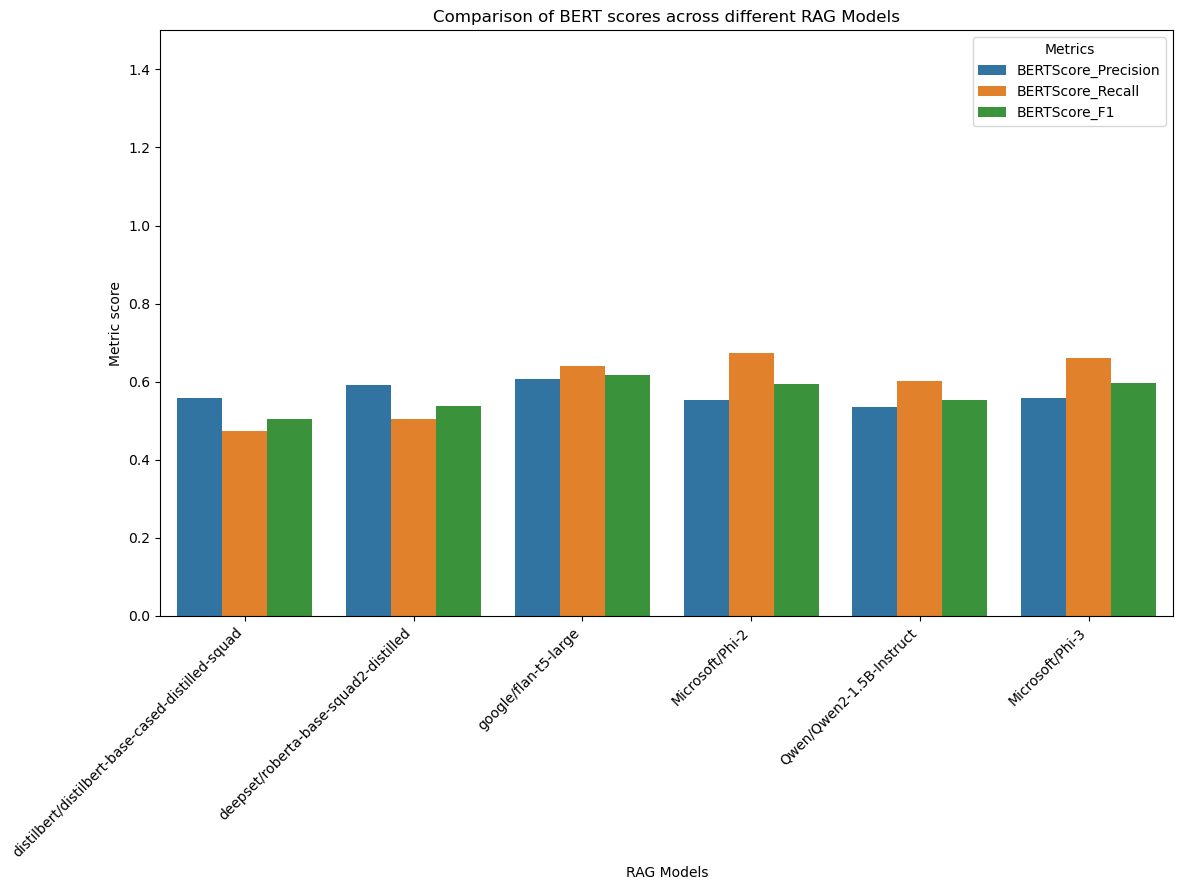

In [57]:
# melt df to plot BERT score based Precision, Recall, F1
melted_df = RAGmodel_metrics_df[['Model', 'BERTScore_Precision', 'BERTScore_Recall', 'BERTScore_F1']].melt(id_vars='Model', var_name='Metric', value_name='Value')

# Plot
plt.figure(figsize=(12, 9))
sns.barplot(data=melted_df, x='Model', y='Value', hue='Metric')
plt.title('Comparison of BERT scores across different RAG Models')
plt.xticks(rotation=45, ha='right')
plt.xlabel('RAG Models')
plt.ylabel('Metric score')
plt.ylim(0.0, 1.5)
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

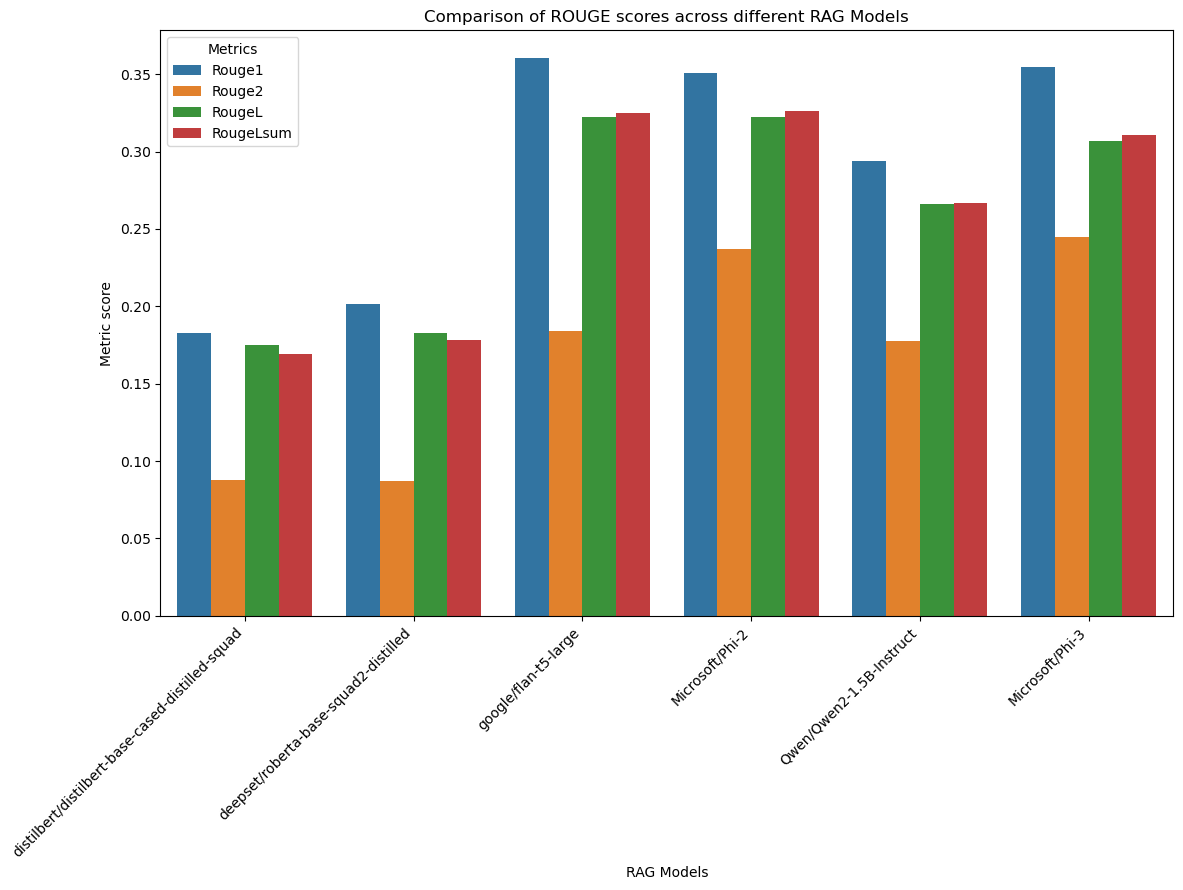

In [58]:
# melt df to plot ROUGE scores
melted_df = RAGmodel_metrics_df[['Model', 'Rouge1', 'Rouge2', 'RougeL', 'RougeLsum']].melt(id_vars='Model', var_name='Metric', value_name='Value')

# Plot
plt.figure(figsize=(12, 9))
sns.barplot(data=melted_df, x='Model', y='Value', hue='Metric')
plt.title('Comparison of ROUGE scores across different RAG Models')
plt.xticks(rotation=45, ha='right')
plt.xlabel('RAG Models')
plt.ylabel('Metric score')
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

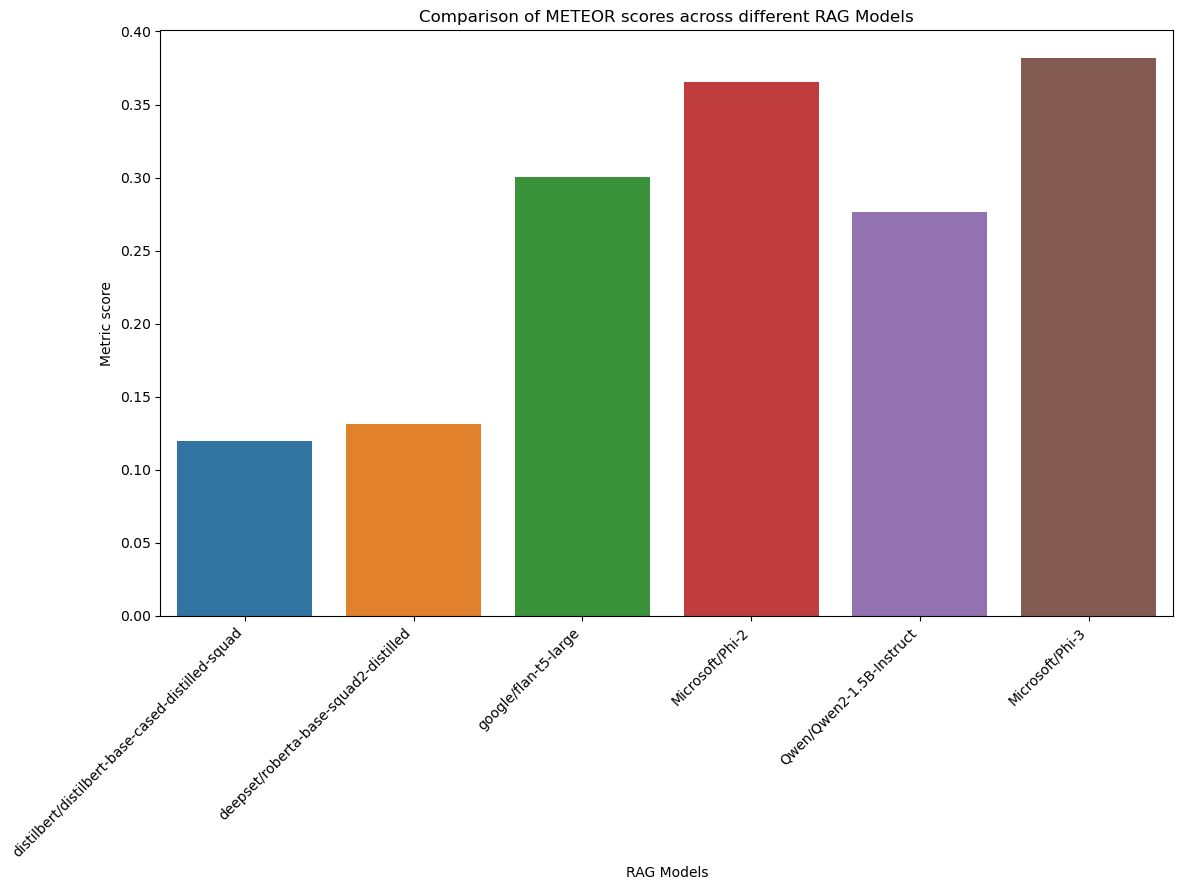

In [59]:
# Plot METEOR scores
plt.figure(figsize=(12, 9))
sns.barplot(data=RAGmodel_metrics_df, x='Model', y='METEOR')
plt.title('Comparison of METEOR scores across different RAG Models')
plt.xticks(rotation=45, ha='right')
plt.xlabel('RAG Models')
plt.ylabel('Metric score')
plt.tight_layout()
plt.show()